# Noise simulator

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/mindspore_noise_simulator.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/mindspore_noise_simulator.py)&emsp;
[![View source on Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/noise_simulator.ipynb)

## ChannelAdder

`ChannelAdder` is a processor that can add specific channels at specific positions in the quantum circuit, such as adding a bit flip channel after a measurement gate. The `ChannelAdder` class mainly consists of three functions: `_accepter()`, `_excluder()`, and `_handler(BasicGate)`, whose functions are as follows:

- `_accepter()`: Returns a list of functions called the accept rule set, where each accept rule function takes a quantum gate as input. When the function returns `True`, we can add a channel after that quantum gate.

- `_excluder()`: Returns a list of functions called the reject rule set, where each reject rule function takes a quantum gate as input. When the function returns `True`, we reject adding a channel after that quantum gate.

- `_handler(BasicGate)`: Takes a quantum gate as input and returns a section of the quantum circuit that represents a custom channel added after the input quantum gate.

We redefine the `__call__` function of the `ChannelAdder` class and you can directly call `ChannelAdder` to generate the processed quantum circuit.
Here are several types of `ChannelAdder`.

### BitFlipAdder

The interface definition of `BitFlipAdder` is:

```python
BitFlipAdder(flip_rate: float, with_ctrl=True, focus_on: int = None, add_after: bool = True)
```

This `Adder` adds a bit flip channel after a quantum gate. The arguments of the interface are:

- **flip_rate** (float): The flip probability of the bit flip channel.
- **with_ctrl** (bool): Whether to add bits on the control bit. Default value: ``True``.
- **focus_on** (bool): Only apply this noise channel to ``focus_on`` bits. If it is ``None``, it will act on all bits of the quantum gate. Default value: ``None``.
- **add_after** (bool): Whether to add the channel after the quantum gate. If it is ``False``, the channel will be added before the quantum gate. Default value: ``True``.

For example, we can add a bit flip channel with a flip probability of ``0.3`` after each quantum gate in the given quantum circuit:

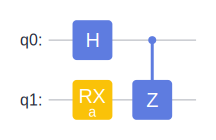

In [1]:
from mindquantum.core.circuit.channel_adder import BitFlipAdder
from mindquantum.core import gates as G
from mindquantum.core.circuit import Circuit

circ = Circuit()+G.H(0)+G.RX('a').on(1)+G.Z(1, 0)
circ.svg()

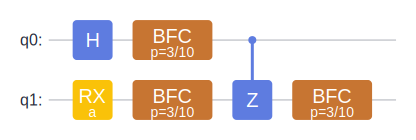

In [2]:
bit_flip_adder = BitFlipAdder(0.3, with_ctrl=False)
new_circ = bit_flip_adder(circ)
new_circ.svg()

### MeasureAccepter

```python
MeasureAccepter()
```

This `Adder` selects corresponding measurement gates. It is currently only an `Accepter` and does not change any gates in the quantum circuit. It needs to be used with other `Adders` such as `MixerAdder`.

### MixerAdder

```python
MixerAdder(adders: typing.List[ChannelAdderBase])
```

`MixerAdder` can mix multiple `Adder`s to ensure that the quantum gates are added in sequence according to the `_handler` generated by each `Adder` when the accept function set and reject function set of each quantum gate in each `Adder` are satisfied at the same time.

For example, we can mix `BitFlipAdder` and `MeasureAccepter` mentioned above to achieve the function of adding bit flip channels only before measurement gates:

MixerAdder<
  BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  MeasureAccepter<>
>


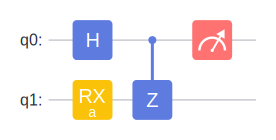

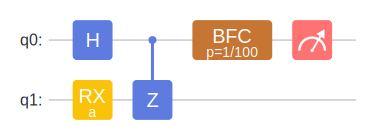

In [3]:
from IPython.display import display_svg
from mindquantum.core.circuit.channel_adder import MixerAdder, MeasureAccepter

mixer = MixerAdder([
    BitFlipAdder(flip_rate=0.01),
    MeasureAccepter(),
], add_after=False)
print(mixer)

circ = Circuit() + G.H(0) + G.RX('a').on(1) + G.Z(1, 0) + G.Measure().on(0)
display_svg(circ.svg())
new_circ = mixer(circ)
new_circ.svg()

### SequentialAdder

```python
SequentialAdder(adders: typing.List[ChannelAdderBase])
```

`SequentialAdder` is a class composed of multiple `Adder`s in sequence. The quantum circuit will be processed by the `Adder`s in `SequentialAdder` in turn to generate the final quantum circuit. For example, we want to construct a quantum circuit that first adds a bit flip channel with $p=0.01$ before the measurement gate, and then adds a depolarizing channel with $p=0.05$ after the non-measurement gate and non-noise channel on the `q1` bit.

### Custom `Adder`

First, we customize an `Adder` that adds a bit flip channel to a specific bit:

In [4]:
from mindquantum.core.circuit.channel_adder import ChannelAdderBase, SequentialAdder

class CustomDepolarizingAdder(ChannelAdderBase):
    def __init__(self, q, p):
        self.q = q
        self.p = p
        super().__init__()

    def _accepter(self):
        return [lambda x: self.q in x.obj_qubits or self.q in x.ctrl_qubits]

    def _excluder(self):
        return  [lambda x: isinstance(x, (G.Measure, G.NoiseGate))]

    def _handler(self, g):
        return Circuit([G.DepolarizingChannel(self.p).on(self.q)])

    def __repr__(self):
        return f"CustomDepolarizingAdder<q={self.q}, flip_rate={self.p}>"

seq_adder = SequentialAdder([
    MixerAdder([
        MeasureAccepter(),
        BitFlipAdder(flip_rate=0.01),
    ], add_after=False),
    CustomDepolarizingAdder(q=1, p=0.05),
])
print(seq_adder)

SequentialAdder<
  MixerAdder<
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
  CustomDepolarizingAdder<q=1, flip_rate=0.05>
>


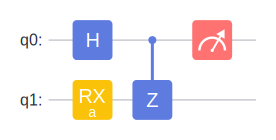

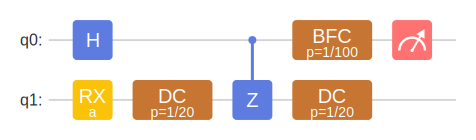

In [5]:
circ = Circuit() + G.H(0) + G.RX('a').on(1) + G.Z(1, 0) + G.Measure().on(0)
display_svg(circ.svg())
new_circ = seq_adder(circ)
new_circ.svg()

The custom quantum channel above can also be constructed using the predefined channels in MindQuantum.

In [6]:
from mindquantum.core.circuit import ReverseAdder, NoiseExcluder, NoiseChannelAdder
seq_adder = SequentialAdder([
    MixerAdder([
        MeasureAccepter(),
        BitFlipAdder(flip_rate=0.01),
    ], add_after=False),
    MixerAdder([
        ReverseAdder(MeasureAccepter()),
        NoiseExcluder(),
        NoiseChannelAdder(G.DepolarizingChannel(0.05), focus_on=1),
    ])
])
print(seq_adder)

SequentialAdder<
  MixerAdder<
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
  MixerAdder<
    ReverseAdder<
      MeasureAccepter<>
    >
    NoiseExcluder<>
    NoiseChannelAdder<channel=DC(p=1/20), with_ctrl=True>
  >
>


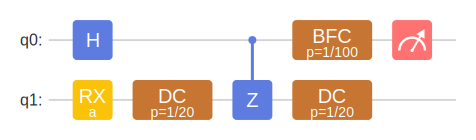

In [7]:
seq_adder(circ).svg()

### A more complex example

We now build a more complex `ChannelAdder` example where the noise of single qubit gate operations on different bits of the chip can be ignored, while the two qubit gates have different depolarizing channels on different bits, and the measurement of the circuit has a bit flip error with a flip probability of 0.01.

We assume that the depolarizing channels on different bits are:

In [8]:
dc0 = G.DepolarizingChannel(0.01)
dc1 = G.DepolarizingChannel(0.02)
dc2 = G.DepolarizingChannel(0.03)

Then we define an `Adder` that meets the requirements:

In [9]:
from mindquantum.core.circuit import QubitNumberConstrain
noise_adder = SequentialAdder([
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc0, focus_on=0),
    ]),
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc1, focus_on=1),
    ]),
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc2, focus_on=2),
    ]),
    MixerAdder([
        NoiseExcluder(),
        MeasureAccepter(),
        BitFlipAdder(0.01)
    ], add_after=False),
])
noise_adder

SequentialAdder<
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=1/100), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=1/50), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=0.03), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
>

Suppose the quantum circuit we want to process is the first-order Trotter approximation circuit of the time-evolving Hamiltonian

$$H=a_{01} Z_0Z_1 + a_{12} Z_1Z_2 + b_0 X_0 + b_1 X_1 + b_2 X_2$$

In [10]:
from mindquantum.core.operators import TimeEvolution, QubitOperator

ham = sum([
    QubitOperator('X0', 'b_0'),
    QubitOperator('X1', 'b_1'),
    QubitOperator('X2', 'b_2'),
    QubitOperator('Z0 Z1', 'a_01'),
    QubitOperator('Z1 Z2', 'a_12')
])
ham

 b_0 [X0] +
 b_1 [X1] +
 b_2 [X2] +
a_01 [Z0 Z1] +
a_12 [Z1 Z2]

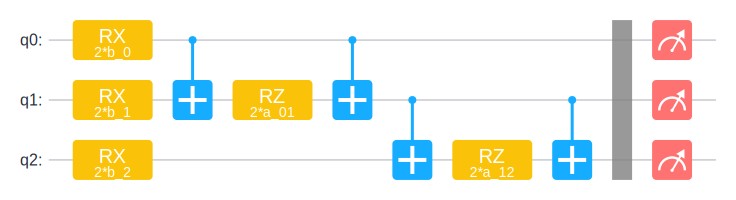

In [11]:
circ = TimeEvolution(ham).circuit
circ.barrier()
circ.measure_all()
circ.svg()

Here is the processed quantum circuit after being processed by the ``noise_adder`` defined above:

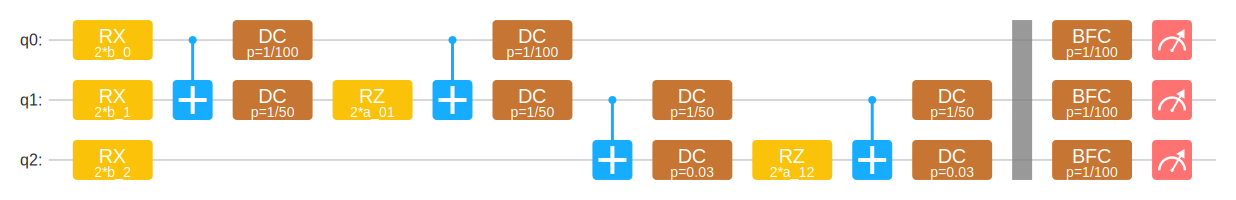

In [12]:
noise_adder(circ).svg()

### `ChannelAdder` list

Here are some of the existing `ChannelAdder`s in MindQuantum and their specific meanings:

|`ChannelAdder`| Function|
|--|--|
|ChannelAdderBase|Add channels before or after quantum gates|
|NoiseChannelAdder|Add a single-bit quantum channel|
|MeasureAccepter|Select measurement gates|
|ReverseAdder|Flip the accept and reject rules of the given channel adder|
|NoiseExcluder|Exclude noise gates|
|BitFlipAdder|Add a bit flip channel before or after the quantum gate|
|MixerAdder|Execute all adders in sequence when the accept and reject sets of the sub-adders are met|
|SequentialAdder|Execute each adder in sequence|
|QubitNumberConstrain|Only apply noise channels to quantum gates with ``n_qubits`` bits|
|QubitIDConstrain|Only apply noise channels to quantum gates with the given bit number|
|GateSelector|Select gate to add noise channel|
|DepolarizingChannelAdder|Add DepolarizingChannel|

For API documentation of `ChannelAdder` in MindQuantum, please refer to: [channel_adder](https://www.mindspore.cn/mindquantum/docs/en/master/mindquantum.core.circuit.html#channel-adder)

## Noise simulator based on `ChannelAdder`

We can combine the various `Adder` defined above with existing simulators to create a noisy simulator.

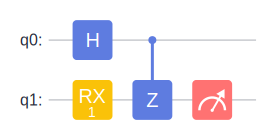

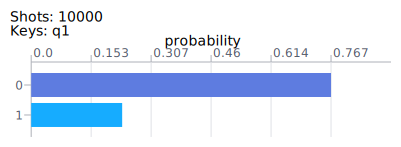

In [13]:
from mindquantum.simulator import Simulator
from mindquantum.simulator.noise import NoiseBackend

noiseless_sim = Simulator('mqvector', 2)
noiseless_circ = Circuit().h(0).rx(1.0, 1).z(1, 0).measure(1)
display_svg(noiseless_circ.svg())
res1 = noiseless_sim.sampling(noiseless_circ, shots=10000)
display(res1.svg())

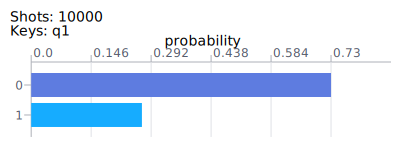

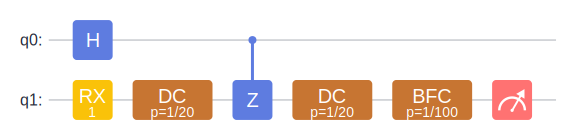

In [14]:
noise_sim = Simulator(NoiseBackend('mqvector', 2, seq_adder))
res2 = noise_sim.sampling(noiseless_circ, shots=10000)
display(res2.svg())
display(noise_sim.backend.transform_circ(noiseless_circ).svg())

In [15]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.0
scipy,1.10.1
numpy,1.21.6
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Wed Aug 23 16:18:06 2023
